<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/Modele000002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

##Python / Colab
from google.colab import files
from google.colab import drive
import os
from IPython.display import Image as imgIPython
from IPython.display import clear_output,display
import IPython
## Tensorflow keras
try:
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Conv2D,Convolution2D,Activation,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dropout,Reshape,BatchNormalization
from tensorflow.keras.layers import concatenate,Concatenate,Subtract,Multiply,Average,Add
from tensorflow.keras.layers import UpSampling2D, Reshape,Flatten
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tensorflow.keras.losses
## Math libraries
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
##Images
from PIL import Image
import cv2
## Graph
from graphviz import render
from graphviz import Digraph,Graph
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
#Dataset
from __future__ import absolute_import, division, print_function, unicode_literals
import random
import pathlib
import shutil
import time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TIPE


#Dataset

In [0]:
#@title { display-mode: "form" }

dossier_TIPE = "/content/drive/My Drive/TIPE/"#@param {type:"string"}

Vérification des datasets

In [3]:
path = dossier_TIPE+"Galaxies_resized/"
dossiers = ["Train","Validation","Test"]
compte = []
for d in dossiers:
    compte.append(len(os.listdir(path+d)))
print([c/sum(compte) for c in compte])
print([c/10 for c in compte])

[0.6089108910891089, 0.297029702970297, 0.09405940594059406]
[24.6, 12.0, 3.8]


Création des classes de dataset Tensorflow

max :  tf.Tensor(1.0, shape=(), dtype=float32)
max :  tf.Tensor(1.0, shape=(), dtype=float32)


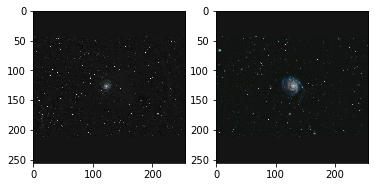

In [4]:
data = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+"Train"+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+"Train"))).batch(5)

#Bruit gaussien origine : https://stackoverflow.com/questions/59286171/gaussian-blur-image-in-dataset-pipeline-in-tensorflow
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)


def apply_blur(img):
    img = tf.reshape(img,[1,256,256,3])
    blur = _gaussian_kernel(3, 2, 3, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return tf.reshape(img,[256,256,3])

def open(x):
    """Modification par image"""
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    print("max : ",tf.reduce_max(img))
    img = tf.image.resize(img, [256, 256])
    img = tf.clip_by_value(img,0,1)
    #Bruitage
    img_noise = tf.image.adjust_saturation(img,.8)
    img_noise = apply_blur(img_noise)
    img_noise = tf.image.adjust_contrast(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.1,maxval=0.2)))
    ajout = 0.1
    img_noise = img_noise+tf.concat([tf.ones(shape=[256,256,1])*ajout,tf.zeros(shape=[256,256,2])],axis=-1)
    img_noise = tf.image.adjust_brightness(img_noise,-ajout)
    img_noise = tf.image.adjust_hue(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.06,maxval=0.09)))
    img_noise = tf.clip_by_value(img_noise,0,1)
    return img,img_noise

res = data
file_path = next(iter(res))
image,img_noise = open(file_path[0])
plt.subplot(1,2,1)
plt.imshow(image)
file_path = next(iter(res))
image,img_noise = open(file_path[0])
plt.subplot(1,2,2)
plt.imshow(image)



In [0]:
#D'après https://stackoverflow.com/questions/54590363/create-tensorflow-dataset-from-image-local-directory
class ArtificialDataset(tf.data.Dataset):
    #Bruit gaussien origine : https://stackoverflow.com/questions/59286171/gaussian-blur-image-in-dataset-pipeline-in-tensorflow
    _COMPTEUR = 0
    def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
        """Génère le noyau de la couche de convolution du flou gaussien"""
        x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
        g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
        g_norm2d = tf.pow(tf.reduce_sum(g), 2)
        g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
        g_kernel = tf.expand_dims(g_kernel, axis=-1)
        return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

    def apply_blur(img):
        """Applique le flou gaussien"""
        img = tf.reshape(img,[1,256,256,3])
        blur = _gaussian_kernel(3, 2, 3, img.dtype)
        img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
        return tf.reshape(img,[256,256,3])

    def open_imgs(x):
        """Modification par image"""
        img = tf.io.read_file(x)
        img = tf.image.decode_jpeg(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [256, 256])
        img = tf.clip_by_value(img,0,1)
        #Bruitage
        img_noise = tf.image.adjust_saturation(img,.8)
        img_noise = apply_blur(img_noise)
        img_noise = tf.image.adjust_contrast(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.1,maxval=0.2)))
        ajout = 0.1
        img_noise = img_noise+tf.concat([tf.ones(shape=[256,256,1])*ajout,tf.zeros(shape=[256,256,2])],axis=-1)
        img_noise = tf.image.adjust_brightness(img_noise,-ajout)
        img_noise = tf.image.adjust_hue(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.06,maxval=0.09)))
        img_noise = tf.clip_by_value(img_noise,0,1)
        return img,img_noise
        
    def _generator():
        for img_batch in ArtificialDataset.donnees:
            refs,entrees = [],[]
            for i,img in enumerate(img_batch):
                clean,noise = ArtificialDataset.open_imgs(img)
                refs.append(clean)
                if i < 5:
                    entrees.append(noise)
                else:
                    entrees.append(clean)
            refs = tf.stack(refs)
            entrees = tf.stack(entrees)
            yield (refs,entrees)
    
    def __new__(cls,nom):
        ArtificialDataset.donnees = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+nom+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+nom))).batch(10)
        #voir doc from_generator https://github.com/tensorflow/tensorflow/blob/f2b2563c6ce2001a117cd7adb36f303903e907ec/tensorflow/python/data/ops/dataset_ops.py#L669
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float32,tf.dtypes.float32),
            output_shapes=(tf.TensorShape([None,256,256,3]), tf.TensorShape([None,256,256,3])), #https://www.tensorflow.org/api_docs/python/tf/TensorShape?version=nightly
            args=None
        )


Test de la classe

In [0]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.05)
    tf.print("Execution time:", time.perf_counter() - start_time)

In [32]:
for nb in range(1,15):
    for essai in range(20):
        print("**********Identifiant********")
        print("%d,%d"%(nb,essai))
        benchmark(ArtificialDataset(nom="Train").prefetch(nb))

**********Identifiant********
1,0
Execution time: 31.938609447999625
**********Identifiant********
1,1
Execution time: 31.600254962999315
**********Identifiant********
1,2
Execution time: 31.66269309100244
**********Identifiant********
1,3
Execution time: 32.023232159001054
**********Identifiant********
1,4
Execution time: 31.816109988998505
**********Identifiant********
1,5
Execution time: 31.957302554001217
**********Identifiant********
1,6
Execution time: 31.80761662900113
**********Identifiant********
1,7
Execution time: 31.838376706000417
**********Identifiant********
1,8
Execution time: 31.538516616998095
**********Identifiant********
1,9
Execution time: 31.817225540002255
**********Identifiant********
1,10
Execution time: 31.762403620999976
**********Identifiant********
1,11
Execution time: 32.33936953599914
**********Identifiant********
1,12
Execution time: 32.14707956699931
**********Identifiant********
1,13
Execution time: 32.66716118499971
**********Identifiant********
1,14


In [0]:
#Parse output
text = """**********Identifiant********
1,0
Execution time: 31.938609447999625
**********Identifiant********
1,1
Execution time: 31.600254962999315
**********Identifiant********
1,2
Execution time: 31.66269309100244
**********Identifiant********
1,3
Execution time: 32.023232159001054
**********Identifiant********
1,4
Execution time: 31.816109988998505
**********Identifiant********
1,5
Execution time: 31.957302554001217
**********Identifiant********
1,6
Execution time: 31.80761662900113
**********Identifiant********
1,7
Execution time: 31.838376706000417
**********Identifiant********
1,8
Execution time: 31.538516616998095
**********Identifiant********
1,9
Execution time: 31.817225540002255
**********Identifiant********
1,10
Execution time: 31.762403620999976
**********Identifiant********
1,11
Execution time: 32.33936953599914
**********Identifiant********
1,12
Execution time: 32.14707956699931
**********Identifiant********
1,13
Execution time: 32.66716118499971
**********Identifiant********
1,14
Execution time: 32.14708272699863
**********Identifiant********
1,15
Execution time: 31.40608625800087
**********Identifiant********
1,16
Execution time: 31.6430662069979
**********Identifiant********
1,17
Execution time: 31.86716656900171
**********Identifiant********
1,18
Execution time: 31.8212244009992
**********Identifiant********
1,19
Execution time: 31.917409302001033
**********Identifiant********
2,0
Execution time: 32.13157517000218
**********Identifiant********
2,1
Execution time: 31.6713603850003
**********Identifiant********
2,2
Execution time: 32.20884434099935
**********Identifiant********
2,3
Execution time: 32.99879359800252
**********Identifiant********
2,4
Execution time: 32.35469177799678
**********Identifiant********
2,5
Execution time: 31.81365524300054
**********Identifiant********
2,6
Execution time: 34.71248093599934
**********Identifiant********
2,7
Execution time: 32.22221288799847
**********Identifiant********
2,8
Execution time: 31.66002105000007
**********Identifiant********
2,9
Execution time: 31.64386737699897
**********Identifiant********
2,10
Execution time: 31.452800703998946
**********Identifiant********
2,11
Execution time: 32.01790513499873
**********Identifiant********
2,12
Execution time: 32.4041082099975
**********Identifiant********
2,13
Execution time: 31.98295023800165
**********Identifiant********
2,14
Execution time: 31.39102280700172
**********Identifiant********
2,15
Execution time: 31.440324856997904
**********Identifiant********
2,16
Execution time: 31.312581333997514
**********Identifiant********
2,17
Execution time: 31.46282544100177
**********Identifiant********
2,18
Execution time: 31.756201591997524
**********Identifiant********
2,19
Execution time: 32.007551385002444
**********Identifiant********
3,0
Execution time: 31.821182244999363
**********Identifiant********
3,1
Execution time: 31.898406004998833
**********Identifiant********
3,2
Execution time: 32.3205604169998
**********Identifiant********
3,3
Execution time: 31.69703098100217
**********Identifiant********
3,4
Execution time: 31.691447345001507
**********Identifiant********
3,5
Execution time: 31.98721827600093
**********Identifiant********
3,6
Execution time: 31.95033503400191
**********Identifiant********
3,7
Execution time: 31.75530889700167
**********Identifiant********
3,8
Execution time: 32.4033196700002
**********Identifiant********
3,9
Execution time: 32.140959547999955
**********Identifiant********
3,10
Execution time: 32.585711470001115
**********Identifiant********
3,11
Execution time: 32.32121733200256
**********Identifiant********
3,12
Execution time: 33.326632222000626
**********Identifiant********
3,13
Execution time: 32.370761479000066
**********Identifiant********
3,14
Execution time: 31.7393254660019
**********Identifiant********
3,15
Execution time: 31.758026913998037
**********Identifiant********
3,16
Execution time: 31.763949469997897
**********Identifiant********
3,17
Execution time: 31.692914692997874
**********Identifiant********
3,18
Execution time: 31.781758180000907
**********Identifiant********
3,19
Execution time: 31.772276325002167
**********Identifiant********
4,0
Execution time: 31.68821367200144
**********Identifiant********
4,1
Execution time: 32.176269323997985
**********Identifiant********
4,2
Execution time: 32.24467222000021
**********Identifiant********
4,3
Execution time: 31.622298711998155
**********Identifiant********
4,4
Execution time: 31.484300549996988
**********Identifiant********
4,5
Execution time: 31.70114536300025
**********Identifiant********
4,6
Execution time: 32.205178561998764
**********Identifiant********
4,7
Execution time: 32.57381476199953
**********Identifiant********
4,8
Execution time: 32.0472381139989
**********Identifiant********
4,9
Execution time: 32.15938672899938
**********Identifiant********
4,10
Execution time: 31.977441318002093
**********Identifiant********
4,11
Execution time: 31.896650705002685
**********Identifiant********
4,12
Execution time: 31.308268712000427
**********Identifiant********
4,13
Execution time: 31.51254130899906
**********Identifiant********
4,14
Execution time: 31.75447091100068
**********Identifiant********
4,15
Execution time: 31.779545657998824
**********Identifiant********
4,16
Execution time: 32.17527318000066
**********Identifiant********
4,17
Execution time: 32.30886778100103
**********Identifiant********
4,18
Execution time: 32.05674638399796
**********Identifiant********
4,19
Execution time: 31.958264455999597
**********Identifiant********
5,0
Execution time: 32.34709036300046
**********Identifiant********
5,1
Execution time: 32.574973365000915
**********Identifiant********
5,2
Execution time: 31.830466081999475
**********Identifiant********
5,3
Execution time: 32.035819599001115
**********Identifiant********
5,4
Execution time: 31.922519626001304
**********Identifiant********
5,5
Execution time: 32.074005910999404
**********Identifiant********
5,6
Execution time: 32.232756188001076
**********Identifiant********
5,7
Execution time: 32.20169637700019
**********Identifiant********
5,8
Execution time: 32.37035858799936
**********Identifiant********
5,9
Execution time: 32.659774302002916
**********Identifiant********
5,10
Execution time: 32.186724207000225
**********Identifiant********
5,11
Execution time: 32.42567591600164
**********Identifiant********
5,12
Execution time: 32.13361514099961
**********Identifiant********
5,13
Execution time: 31.79604518799897
**********Identifiant********
5,14
Execution time: 31.397539693
**********Identifiant********
5,15
Execution time: 31.568310607999592
**********Identifiant********
5,16
Execution time: 31.598183959999005
**********Identifiant********
5,17
Execution time: 31.623907274002704
**********Identifiant********
5,18
Execution time: 31.44412435400227
**********Identifiant********
5,19
Execution time: 31.845247896999354
**********Identifiant********
6,0
Execution time: 31.786942187998648
**********Identifiant********
6,1
Execution time: 31.652200036001886
**********Identifiant********
6,2
Execution time: 31.26523702600025
**********Identifiant********
6,3
Execution time: 31.363151273999392
**********Identifiant********
6,4
Execution time: 31.80375053899843
**********Identifiant********
6,5
Execution time: 31.89495367500058
**********Identifiant********
6,6
Execution time: 32.20611102300245
**********Identifiant********
6,7
Execution time: 32.05581345700193
**********Identifiant********
6,8
Execution time: 32.912673203998565
**********Identifiant********
6,9
Execution time: 33.062063552002655
**********Identifiant********
6,10
Execution time: 31.86646517200279
**********Identifiant********
6,11
Execution time: 31.472435063999
**********Identifiant********
6,12
Execution time: 32.073600960000476
**********Identifiant********
6,13
Execution time: 31.474291491002077
**********Identifiant********
6,14
Execution time: 31.744218601998
**********Identifiant********
6,15
Execution time: 32.2763676709983
**********Identifiant********
6,16
Execution time: 32.01524303699989
**********Identifiant********
6,17
Execution time: 31.977229132000502
**********Identifiant********
6,18
Execution time: 32.12331532299868
**********Identifiant********
6,19
Execution time: 31.45919558999958
**********Identifiant********
7,0
Execution time: 31.53124563900201
**********Identifiant********
7,1
Execution time: 31.19410102999973
**********Identifiant********
7,2
Execution time: 31.29908397199688
**********Identifiant********
7,3
Execution time: 31.91406767099761
**********Identifiant********
7,4
Execution time: 31.867791558001045
**********Identifiant********
7,5
Execution time: 32.151334145000874
**********Identifiant********
7,6
Execution time: 31.839898039001127
**********Identifiant********
7,7
Execution time: 31.44223608700122
**********Identifiant********
7,8
Execution time: 31.31182595199789
**********Identifiant********
7,9
Execution time: 31.279463025999576
**********Identifiant********
7,10
Execution time: 31.476473053000518
**********Identifiant********
7,11
Execution time: 31.176373541999055
**********Identifiant********
7,12
Execution time: 31.21613955900102
**********Identifiant********
7,13
Execution time: 31.370753363000404
**********Identifiant********
7,14
Execution time: 31.59486783600005
**********Identifiant********
7,15
Execution time: 31.678566509999655
**********Identifiant********
7,16
Execution time: 32.017872879001516
**********Identifiant********
7,17
Execution time: 31.987462680001045
**********Identifiant********
7,18
Execution time: 32.11902472099973
**********Identifiant********
7,19
Execution time: 31.766518340999028
**********Identifiant********
8,0
Execution time: 32.05951914400066
**********Identifiant********
8,1
Execution time: 31.94939052599875
**********Identifiant********
8,2
Execution time: 32.325962615002936
**********Identifiant********
8,3
Execution time: 32.174254189998464
**********Identifiant********
8,4
Execution time: 32.17621098800009
**********Identifiant********
8,5
Execution time: 32.304605593002634
**********Identifiant********
8,6
Execution time: 31.83865522999986
**********Identifiant********
8,7
Execution time: 31.84124457800135
**********Identifiant********
8,8
Execution time: 32.07640376500058
**********Identifiant********
8,9
Execution time: 32.75618381800086
**********Identifiant********
8,10
Execution time: 32.334088447001704
**********Identifiant********
8,11
Execution time: 32.96196281599987
**********Identifiant********
8,12
Execution time: 32.65706801000124
**********Identifiant********
8,13
Execution time: 32.57303707000028
**********Identifiant********
8,14
Execution time: 32.36684020199755
**********Identifiant********
8,15
Execution time: 32.49507269300011
**********Identifiant********
8,16
Execution time: 32.61476926600153
**********Identifiant********
8,17
Execution time: 32.62472347100265
**********Identifiant********
8,18
Execution time: 32.30978104300084
**********Identifiant********
8,19
Execution time: 32.625731372998416
**********Identifiant********
9,0
Execution time: 32.87590562300102
**********Identifiant********
9,1
Execution time: 33.08588999100175
**********Identifiant********
9,2
Execution time: 33.63360301799912
**********Identifiant********
9,3
Execution time: 32.54933489399991
**********Identifiant********
9,4
Execution time: 32.63147791600204
**********Identifiant********
9,5
Execution time: 32.200929656999506
**********Identifiant********
9,6
Execution time: 32.83507493399884
**********Identifiant********
9,7
Execution time: 31.86560486000235
**********Identifiant********
9,8
Execution time: 32.471576748997904
**********Identifiant********
9,9
Execution time: 32.10882855700038
**********Identifiant********
9,10
Execution time: 32.01596141299888
**********Identifiant********
9,11
Execution time: 32.036173487998894
**********Identifiant********
9,12
Execution time: 31.346382505998918
**********Identifiant********
9,13
Execution time: 30.730259562002175
**********Identifiant********
9,14
Execution time: 31.685692756000208
**********Identifiant********
9,15
Execution time: 31.668926526999712
**********Identifiant********
9,16
Execution time: 31.940007309000066
**********Identifiant********
9,17
Execution time: 32.074823203998676
**********Identifiant********
9,18
Execution time: 32.410576928999944
**********Identifiant********
9,19
Execution time: 32.79519433499809
**********Identifiant********
10,0
Execution time: 32.23774770000091
**********Identifiant********
10,1
Execution time: 32.229121878001024
**********Identifiant********
10,2
Execution time: 31.994131228002516
**********Identifiant********
10,3
Execution time: 32.205028011998365
**********Identifiant********
10,4
Execution time: 31.92625750699881
**********Identifiant********
10,5
Execution time: 31.736420400997304
**********Identifiant********
10,6
Execution time: 31.59104351300266
**********Identifiant********
10,7
Execution time: 31.68603331399936
**********Identifiant********
10,8
Execution time: 32.16426947299988
**********Identifiant********
10,9
Execution time: 31.728025504999096
**********Identifiant********
10,10
Execution time: 31.734616295001615
**********Identifiant********
10,11
Execution time: 32.155532425000274
**********Identifiant********
10,12
Execution time: 32.29277421000006
**********Identifiant********
10,13
Execution time: 32.18727413200031
**********Identifiant********
10,14
Execution time: 32.351002727999
**********Identifiant********
10,15
Execution time: 32.36989318600172
**********Identifiant********
10,16
Execution time: 32.14093731200046
**********Identifiant********
10,17
Execution time: 32.810356974998285
**********Identifiant********
10,18
Execution time: 34.37350445800257
**********Identifiant********
10,19
Execution time: 32.38307320899912
**********Identifiant********
11,0
Execution time: 32.2216476370013
**********Identifiant********
11,1
Execution time: 32.32260518900148
**********Identifiant********
11,2
Execution time: 32.354732077001245
**********Identifiant********
11,3
Execution time: 32.161858047998976
**********Identifiant********
11,4
Execution time: 32.38477553100165
**********Identifiant********
11,5
Execution time: 32.62530918199991
**********Identifiant********
11,6
Execution time: 32.40036808799778
**********Identifiant********
11,7
Execution time: 32.81375804599884
**********Identifiant********
11,8
Execution time: 32.24953193399779
**********Identifiant********
11,9
Execution time: 32.34771611599717
**********Identifiant********
11,10
Execution time: 32.00104431300133
**********Identifiant********
11,11
Execution time: 32.14711387399802
**********Identifiant********
11,12
Execution time: 31.520800940998015
**********Identifiant********
11,13
Execution time: 32.03705557699868
**********Identifiant********
11,14
Execution time: 32.01957290599967
**********Identifiant********
11,15
Execution time: 32.4757419009984
**********Identifiant********
11,16
Execution time: 32.87494552999851
**********Identifiant********
11,17
Execution time: 32.030342196001584
**********Identifiant********
11,18
Execution time: 33.41561552499843
**********Identifiant********
11,19
Execution time: 33.351393897999515
**********Identifiant********
12,0
Execution time: 32.74176565900052
**********Identifiant********
12,1
Execution time: 32.26216246200056
**********Identifiant********
12,2
Execution time: 32.30751875400165
**********Identifiant********
12,3
Execution time: 32.82700007300082
**********Identifiant********
12,4
Execution time: 32.20076988499932
**********Identifiant********
12,5
Execution time: 32.404516037000576
**********Identifiant********
12,6
Execution time: 32.39540381199913
**********Identifiant********
12,7
Execution time: 31.82099219600059
**********Identifiant********
12,8
Execution time: 31.95324907399845
**********Identifiant********
12,9
Execution time: 31.93282963599995
**********Identifiant********
12,10
Execution time: 31.84339721100332
**********Identifiant********
12,11
Execution time: 32.0571961070018
**********Identifiant********
12,12
Execution time: 32.12696401100038
**********Identifiant********
12,13
Execution time: 32.00930220100054
**********Identifiant********
12,14
Execution time: 32.15591611700074
**********Identifiant********
12,15
Execution time: 32.44519629700153
**********Identifiant********
12,16
Execution time: 32.807930151997425
**********Identifiant********
12,17
Execution time: 32.6961410240001
**********Identifiant********
12,18
Execution time: 32.68840200699924
**********Identifiant********
12,19
Execution time: 32.36122175999844
**********Identifiant********
13,0
Execution time: 32.15259859700018
**********Identifiant********
13,1
Execution time: 32.17941865600005
**********Identifiant********
13,2
Execution time: 32.53543345700018
**********Identifiant********
13,3
Execution time: 32.36072721199889
**********Identifiant********
13,4
Execution time: 32.05310892499983
**********Identifiant********
13,5
Execution time: 32.55057341900101
**********Identifiant********
13,6
Execution time: 32.13356118700176
**********Identifiant********
13,7
Execution time: 32.002112057001796
**********Identifiant********
13,8
Execution time: 31.888316954999027
**********Identifiant********
13,9
Execution time: 31.942702083000768
**********Identifiant********
13,10
Execution time: 32.230879062000895
**********Identifiant********
13,11
Execution time: 32.27009102699958
**********Identifiant********
13,12
Execution time: 32.15265228399949
**********Identifiant********
13,13
Execution time: 32.862024843001564
**********Identifiant********
13,14
Execution time: 32.657825293001224
**********Identifiant********
13,15
Execution time: 32.85782116199698
**********Identifiant********
13,16
Execution time: 32.25018441299835
**********Identifiant********
13,17
Execution time: 31.558439452997845
**********Identifiant********
13,18
Execution time: 31.212416215999838
**********Identifiant********
13,19
Execution time: 31.302451159997872
**********Identifiant********
14,0
Execution time: 31.02652764099912
**********Identifiant********
14,1
Execution time: 31.122765571002674
**********Identifiant********
14,2
Execution time: 31.01662774899887
**********Identifiant********
14,3
Execution time: 31.76004081100109
**********Identifiant********
14,4
Execution time: 31.721069463001186
**********Identifiant********
14,5
Execution time: 31.854689067000436
**********Identifiant********
14,6
Execution time: 31.800924507999298
**********Identifiant********
14,7
Execution time: 31.97769331699965
**********Identifiant********
14,8
Execution time: 31.905726474000403
**********Identifiant********
14,9
Execution time: 31.785221857997385
**********Identifiant********
14,10
Execution time: 32.23323231500035
**********Identifiant********
14,11
Execution time: 32.04849652900157
**********Identifiant********
14,12
Execution time: 32.96137504100261
**********Identifiant********
14,13
Execution time: 32.52979875299934
**********Identifiant********
14,14
Execution time: 33.74628438000218
**********Identifiant********
14,15
Execution time: 32.50349732500035
**********Identifiant********
14,16
Execution time: 32.893892946998676
**********Identifiant********
14,17
Execution time: 32.058288673997595
**********Identifiant********
14,18
Execution time: 32.38301705300182
**********Identifiant********
14,19
Execution time: 32.051861096999346"""
text_traitement = text.split("\n")
L_val = []
for i,l in enumerate(text_traitement):
    if l[0] == "*":
        [nb,essai] = list(map(int,text_traitement[i+1].split(",")))
        t = float(text_traitement[i+2].split(":")[-1].strip())
        L_val.append([nb,essai,t])
L_echant = []
for nb,essai,t in L_val:
    if nb-1 == len(L_echant):#Essais pour un même parametre sur une même ligne
        L_echant.append([t])
    else:
        L_echant[-1].append(t)
#Analyse
import numpy as np, scipy.stats as st
L_moy = list(map(np.mean,L_echant))
# Source https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
L_int = list(map(lambda x:st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x)),L_echant))

param 1 : en moyenne 31.885899 ; 95% entre 31.751829 et 32.019970
param 2 : en moyenne 32.032289 ; 95% entre 31.677422 et 32.387155
param 3 : en moyenne 32.038917 ; 95% entre 31.844864 et 32.232971
param 4 : en moyenne 31.931529 ; 95% entre 31.781267 et 32.081792
param 5 : en moyenne 32.013442 ; 95% entre 31.839749 et 32.187134
param 6 : en moyenne 31.924263 ; 95% entre 31.707350 et 32.141176
param 7 : en moyenne 31.611755 ; 95% entre 31.459059 et 31.764451
param 8 : en moyenne 32.353275 ; 95% entre 32.207954 et 32.498596
param 9 : en moyenne 32.248111 ; 95% entre 31.941892 et 32.554330
param 10 : en moyenne 32.214852 ; 95% entre 31.938977 et 32.490728
param 11 : en moyenne 32.387796 ; 95% entre 32.175261 et 32.600332
param 12 : en moyenne 32.301894 ; 95% entre 32.150737 et 32.453050
param 13 : en moyenne 32.157667 ; 95% entre 31.950014 et 32.365319
param 14 : en moyenne 32.069052 ; 95% entre 31.758661 et 32.379442


<ErrorbarContainer object of 3 artists>

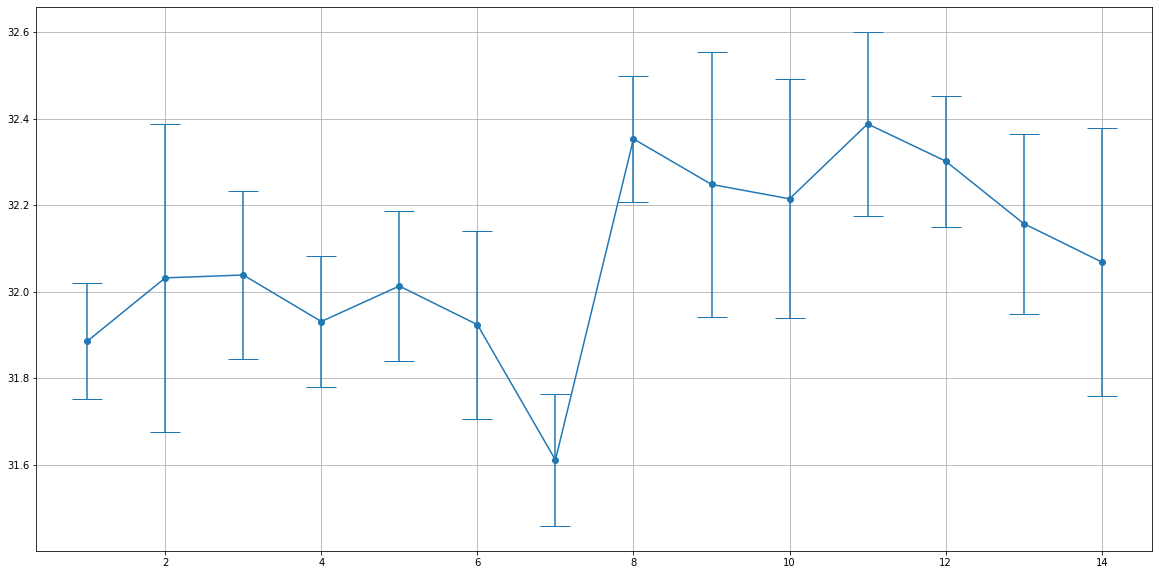

In [56]:
L_ecart = []
for i,[m,inter] in enumerate(zip(L_moy,L_int)):
    print("param %d : en moyenne %f ; 95%% entre %f et %f"%(i+1,m,inter[0],inter[1]))
    L_ecart.append(abs(inter[1]-m))
plt.figure(figsize=(20,10))
plt.subplot(1,1,1)
plt.grid()
plt.errorbar(list(range(1,len(L_moy)+1)),L_moy,yerr=L_ecart,fmt='-o',capsize=15)

<ErrorbarContainer object of 3 artists>

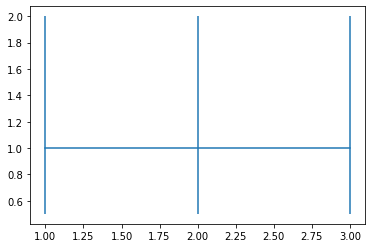

In [38]:
x = [1,2,3]
y = [1,1,1]
errb = [0.5,0.5,0.5]
errh = [1,1,1]
plt.errorbar(x,y,yerr=[errb,errh])